# UQModel : tutorial

This notebook aim to illustrate the use of UQmodels library as provider of KPI to perform system Monitoring on Time series Data. The complete pipleline can be decomposed into 3 step :

1) Data load & preprocessing : (row_stored_data -> ML dataset)

2) Modeling & Post processing : (ML_dataset -> pred & UQmesure -> pred & UQ-KPI)

3) Visualisation & Evaluation : (Target, Pred, UQ-KPI) -> (metrics & visualisation)


In [9]:
%load_ext autoreload
%autoreload 2

import os
import warnings
warnings.filterwarnings("ignore")

import sys
path = '.'
os.chdir(path=path)
ROOT_PATH = "demo"
cwd_path = os.getcwd()
cwd = os.path.basename(cwd_path)

import numpy as np
sys.path.insert(1, '..')
import uqmodels as uqmodels


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1) Data load & preprocessing :

In [10]:
import uqmodels.processing as proc 
import uqmodels.preprocessing.Custom_Preprocessor as preproc
from uqmodels.processing import Data_loader
from uqmodels.processing import Pipeline
from uqmodels.preprocessing.Custom_Preprocessor import dict_to_TS_Dataset
import pickle

#Data loading & Preprocessing
storing = path + '/data/'
filename = 'synthetic_dataset_multivariate.p'

import pickle
# Define a loading API
def load_api(storing,filename,**kwargs):
    return(pickle.load(open(storing+filename,'rb')))

# Instanciate Data_loader 
data_loader = Data_loader(data_loader_api=load_api)

# Apply data_loader to get rowdata
dict_data = data_loader.load({'storing':storing,'filename':filename})
print('Row data : type=',type(dict_data),'key',dict_data.keys())

#Define Pipeline that combine data_loader and preprocesor

# Here preprocessor aim only to recovers already computed feature and targets -> X = dict_data['X'],y=dict_data['y'],ect.
preprocessor = dict_to_TS_Dataset()
pipeline = Pipeline(data_loader=data_loader,list_processors=[preprocessor])

#Define query link to load api and add a 'name' key which is recover by the preprocessor to provide a name to the dataset
list_query = [{'storing':storing,'filename':filename,'name':'Synthetic_data'}]

#It provide a data_generator (yield) that provide each processed data one by one.
dataset_generator = pipeline.transform(list_query) 

# Execute preprocessing pipeline :  
X, y, sample_weight, x_split, context, objective, name = next(dataset_generator)
train = x_split==1
test = np.invert(train)
print('X shape:',X.shape,'y: yshape',y.shape,'Name:',name)

Row data : type= <class 'dict'> key dict_keys(['X', 'Y', 'context', 'X_name', 'train', 'test', 'X_split', 'context_name', 'aux', 'X_bis'])
Pipeline : No cache data found : load data and execute the whole pipeline
X shape: (12000, 19) y: yshape (12000, 3) Name: Synthetic_data


# 2) Modeling & Post processing : (ML_dataset -> pred & UQmesure -> pred & UQ-KPI)

## Using UQestimator & Processing function or Processor object 

# Model UQ by design + Transformation d'une variance en une interval de confiance.

In [11]:
from sklearn.ensemble import RandomForestRegressor
from uqmodels.modelization.ML_estimator.random_forest_UQ import RF_UQEstimator,get_params_dict
from uqmodels.UQModel import UQModel
import uqmodels.postprocessing.UQKPI_Processor as UQProc



# PostProcesseur Instanciation that compute an epistemics lvl score
UQEstimator_initializer = RF_UQEstimator
UQEstimator_parameters = get_params_dict()

# We can use UQestimator as standards estimator : 
UQEstimator = UQEstimator_initializer(**UQEstimator_parameters)
UQEstimator.fit(X[train],y[train])
pred,UQ = UQEstimator.predict(X)
print('pred shape',pred.shape,'Nature of UQ_mesure',UQEstimator.type_UQ,'UQ shape : ',UQ.shape,' (2:var_A,Var_E),(12000:time_step),(3:data dimension)')

# If we want Predictive interval from our UQmeasure :
list_alpha = [0.025,0.16,0.84,0.975]

# We can manually produce Predictive intervals form UQ_processing function :
import uqmodels.postprocessing.UQ_processing as UQ_Process

params_ = UQ_Process.fit_PI(UQ=UQ[:,train],type_UQ=UQEstimator.type_UQ,pred=pred[train],y=None,list_alpha=list_alpha)
PIs_KPIs,_ = UQ_Process.compute_PI(UQ=UQ,type_UQ=UQEstimator.type_UQ,pred=pred,y=None,list_alpha=list_alpha,params_=params_)
print('Using processing function : coverage_empiric',np.round((np.array(PIs_KPIs)[:,test]>y[test]).mean(axis=(1,2))*100,1),' |Coverage_target :',np.array(list_alpha)*100)

# We can do the same using a post processing object : 
import uqmodels.postprocessing.UQKPI_Processor as UQProc

PIs_proc = UQProc.NormalPIs_processor(KPI_parameters={'list_alpha':[0.025,0.16,0.84,0.975]})
params_ = PIs_proc.fit(UQ=UQ[:,train],type_UQ=UQEstimator.type_UQ,pred=pred[train],y=None)
PIs_KPIs = PIs_proc.transform(UQ=UQ,type_UQ=UQEstimator.type_UQ,pred=pred,y=None)
print('Using PIs_processor : coverage_empriric',np.round((np.array(PIs_KPIs)[:,test]>y[test]).mean(axis=(1,2))*100,1),' |Coverage_target :',np.array(list_alpha)*100)

pred shape (12000, 3) Nature of UQ_mesure var_A&E UQ shape :  (2, 12000, 3)  (2:var_A,Var_E),(12000:time_step),(3:data dimension)
Using processing function : coverage_empiric [ 1.3 10.7 90.1 98.8]  |Coverage_target : [ 2.5 16.  84.  97.5]
Using PIs_processor : coverage_empriric [ 1.3 10.7 90.1 98.8]  |Coverage_target : [ 2.5 16.  84.  97.5]


## Using UQModel pipeline for predictive interval 

In [12]:
from uqmodels.UQModel import UQModel

# We can do the same using a UQModel object:
PIs_proc = UQProc.NormalPIs_processor(KPI_parameters={'list_alpha':[0.025,0.16,0.84,0.975]})
RF_UQModel = UQModel(UQEstimator_initializer,
                     UQEstimator_parameters,
                     name='RF_UQ',
                     predictor=None,
                     list_predict_KPI_processors=[PIs_proc],
                     list_score_KPI_processors=[])
# Firstly UQModel fit UQestimator and KPI_processor
RF_UQModel.fit(X[train],y[train])
pred,(PIs_KPIs) = RF_UQModel.predict(X)
print('Using UQModel pipeline : coverage_empriric',np.round((np.array(PIs_KPIs)[:,test]>y[test]).mean(axis=(1,2))*100,1),' |Coverage_target :',np.array(list_alpha)*100)

if(True): # Test load save UQModels wrapper procedure
    # Save fitted UQEstimator and KPI-Processors
    RF_UQModel.save('./model')

    # New model 
    RF_UQModel = UQModel()
    # Load fitted UQEstimator and KPI-Processors
    RF_UQModel.load(path='model/RF_UQ/')

#Then it apply the whole pipeline
pred,(PIs_KPIs) = RF_UQModel.predict(X)

# And perform comparaison of theorical vs real coverage
print('Using UQModel pipeline : coverage_empriric',np.round((np.array(PIs_KPIs)[:,test]>y[test]).mean(axis=(1,2))*100,1),' | Coverage_target :',np.array(list_alpha)*100)

Using UQModel pipeline : coverage_empriric [ 1.3 10.9 90.5 98.8]  |Coverage_target : [ 2.5 16.  84.  97.5]
Using UQModel pipeline : coverage_empriric [ 1.3 10.9 90.5 98.8]  | Coverage_target : [ 2.5 16.  84.  97.5]


## Using UQModel pipeline for multi KPI at inference  (UQMesure, Predictive interval and model unreliability score) and after observation (Anomaly score)

In [13]:
# We can also create a more complexe UQmodel that handle several UQKPI_Processor to build at inference (UQMesure, Predictive interval and model unreliability score) and after observation (Anomaly score)

from uqmodels.processing import Cache_manager

name = "RF_UQ_tuto"
# Specification of the UQestimator
UQEstimator_initializer = RF_UQEstimator
UQEstimator_parameters = get_params_dict()

# Instanciation of PostProcesseur that provide UQ measure.
UQ_proc = UQProc.UQKPI_Processor()

# PostProcesseur that compute Predictive intervals
PIs_proc = UQProc.NormalPIs_processor(KPI_parameters={'list_alpha':[0.025,0.16,0.84,0.975]})

# PostProcesseur  that compute an epistemics lvl score
Elvl_proc = UQProc.Epistemicscorelvl_processor()

# PostProcesseur Instanciation that compute Anom score
Anom_proc_no_UQ= UQProc.Anomscore_processor(KPI_parameters={'beta':0.005,'with_born':True,'q_var':0,'k_var_e':0,'q_var_e':0,'k_var_e':0,'q_Eratio':0})
Anom_proc_no_epistemic = UQProc.Anomscore_processor(KPI_parameters={'beta':0.005,'with_born':True,'q_var_e':0,'k_var_e':0,'q_Eratio':0})
Anom_proc_with_epistemic = UQProc.Anomscore_processor(KPI_parameters={'beta':0.005,'with_born':True})

# Instanciation of the UQmodel modeling pipeline
RF_UQModel = UQModel(UQEstimator_initializer,
                     UQEstimator_parameters,
                     name=name,
                     predictor=None,
                     list_predict_KPI_processors=[UQ_proc,PIs_proc,Elvl_proc],
                     list_score_KPI_processors=[Anom_proc_no_UQ,Anom_proc_no_epistemic,Anom_proc_with_epistemic])

# Fit procedure
RF_UQModel.fit(X[train],y[train])

# Save fitted UQEstimator and KPI-Processors
RF_UQModel.save('./model')

# New model 
RF_UQModel = UQModel()

# Load fitted UQEstimator and KPI-Processors
RF_UQModel.load(path='model/'+name)
    
pred,(UQ,PIs,Elvl) = RF_UQModel.predict(X)
KPI_ANOM1, KPI_ANOM2, KPI_ANOM3 = RF_UQModel.score(X,y)

(KPI_anom_no_UQ,born_no_UQ) = KPI_ANOM1
(KPI_anom_without_epistemic,born_without_epistemic) = KPI_ANOM2
(KPI_anom_with_epistemic,born_with_epistemic) = KPI_ANOM3

# 3) Visualisation & Evaluation : (Target, Pred, UQ-KPI) -> (metrics & visualisation)

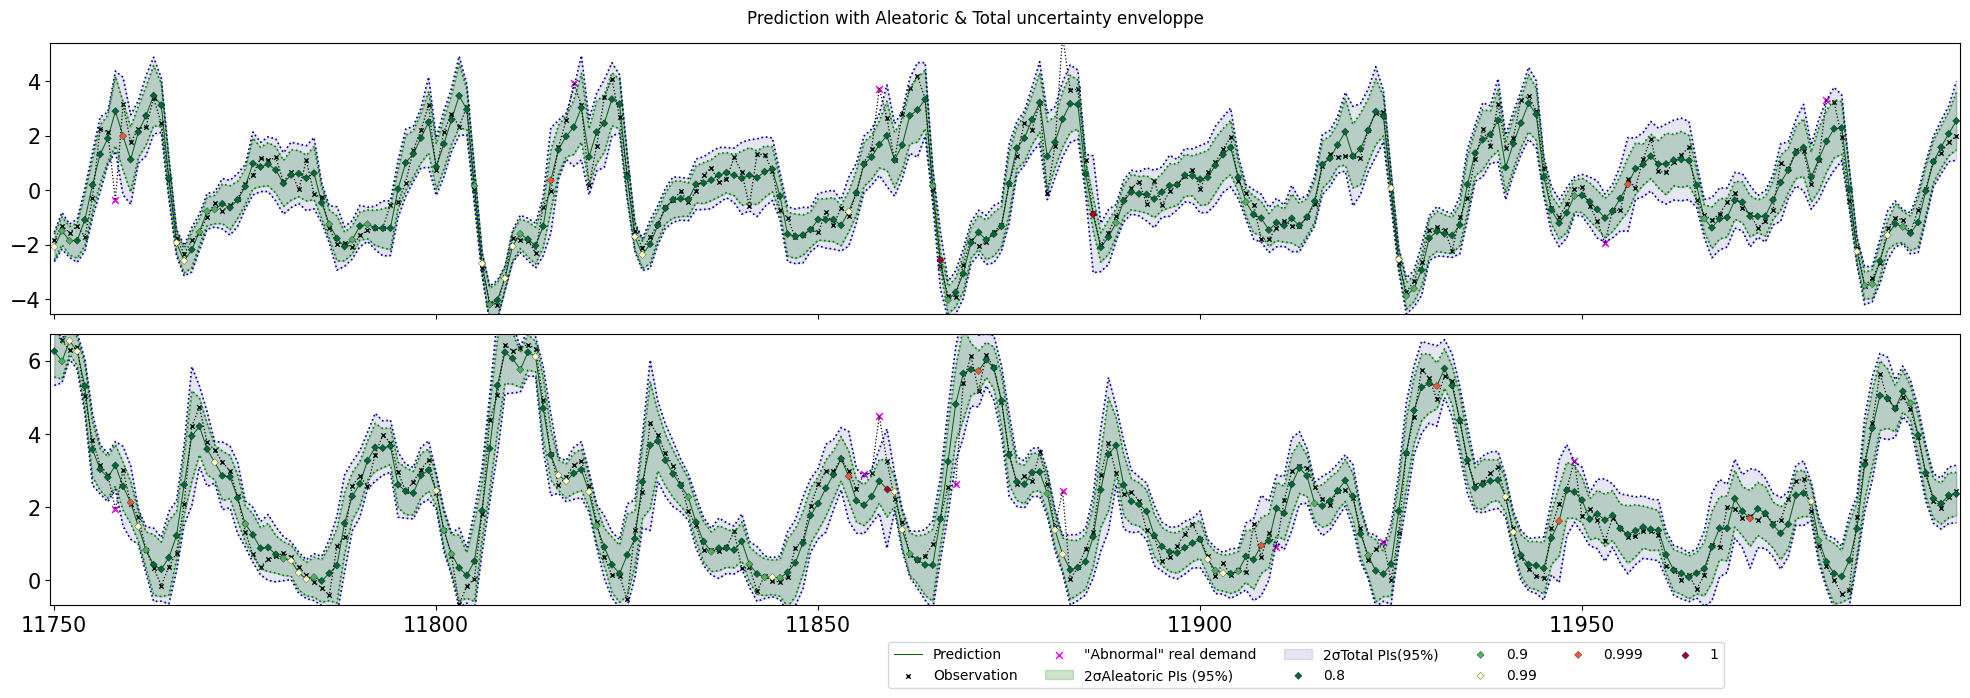

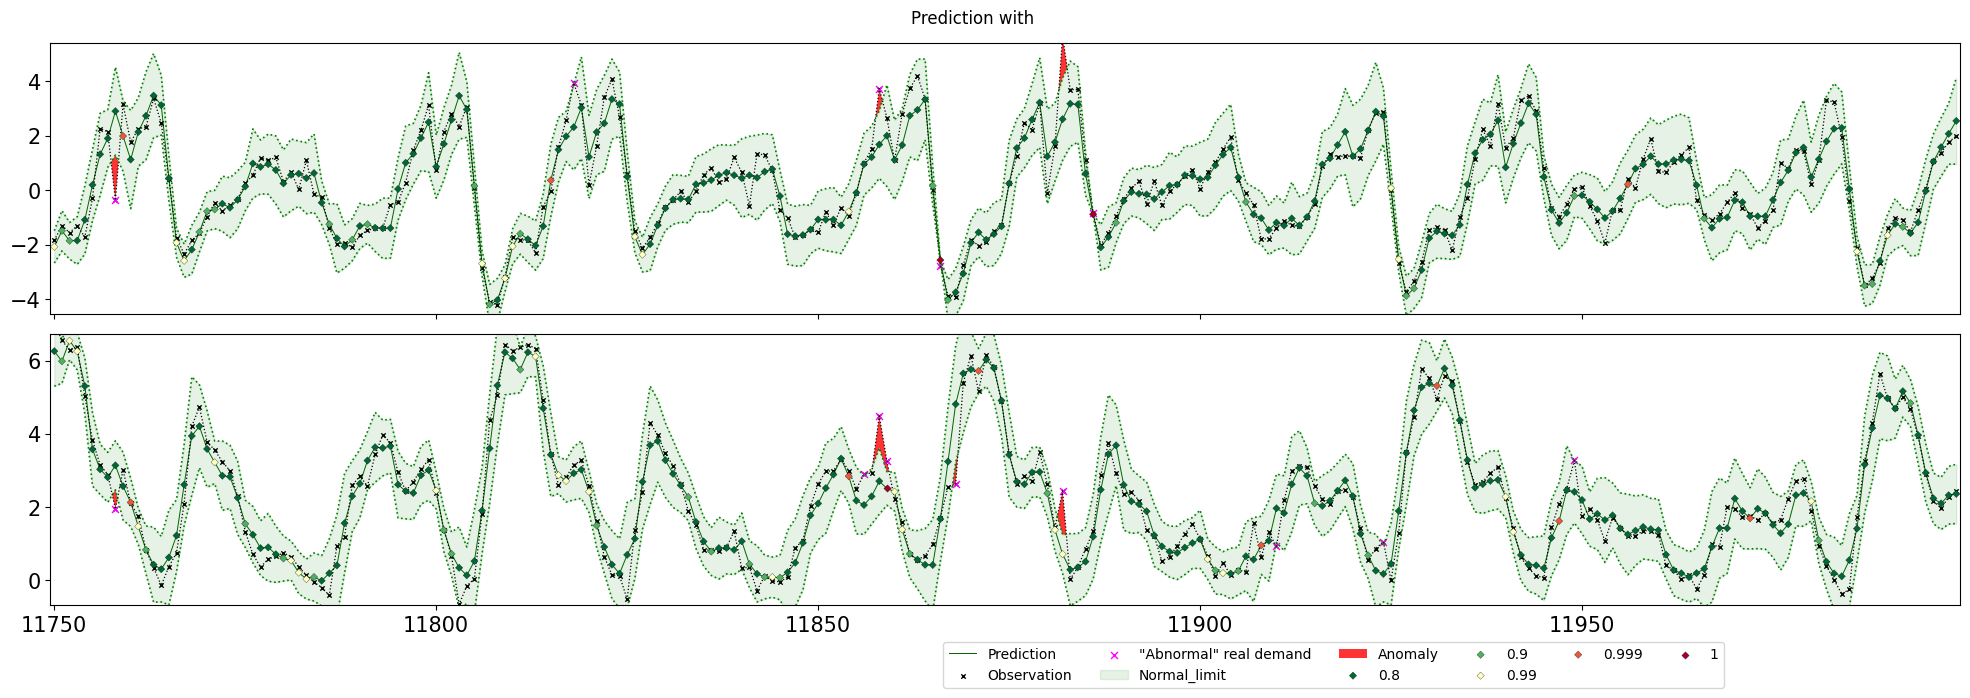

Q_bot emp val:2.5% [99.34166667 99.425      99.45      ] Q_top emp val:97 [92.70833333 93.25       93.025     ]
Elvl : [0.0, 1.0, 2.0, 3.0, 4.0, 4.0, 5.0]


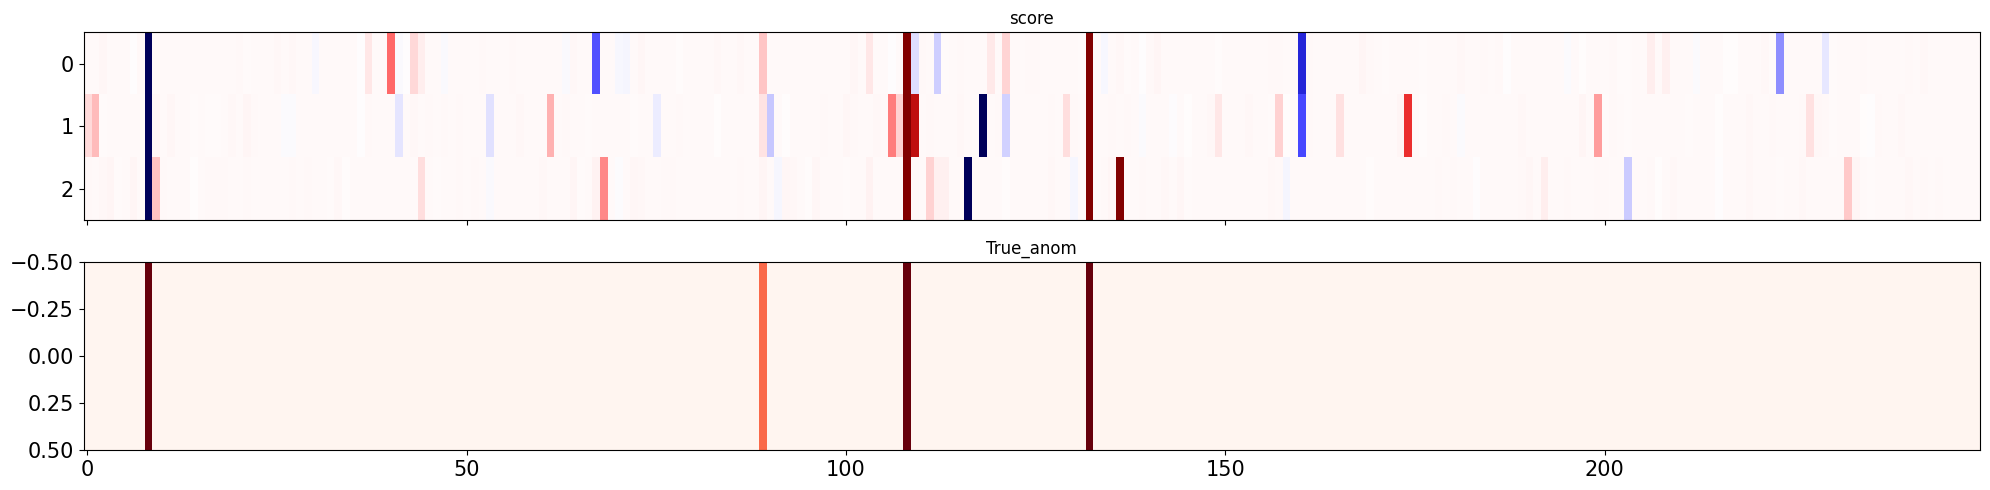

In [14]:
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import uqmodels.visualization.visualization as visu

output = pred,UQ
f_obs = np.arange(11750,12000)
visu.uncertainty_plot(y,output,context=None,size=(20, 7),f_obs=f_obs,name='Prediction with Aleatoric & Total uncertainty enveloppe',mode_res=False,dim=np.arange(2),type_UQ=RF_UQModel.type_UQ)
visu.uncertainty_plot(y,output,context=None,born=born_with_epistemic,size=(20, 7),f_obs=f_obs,name='Prediction with ',mode_res=False,dim=np.arange(2),type_UQ=RF_UQModel.type_UQ)

print('Q_bot emp val:2.5%', (PIs[0]<y).mean(axis=0)*100,'Q_top emp val:97',(PIs[1]<y).mean(axis=0)*100)
print('Elvl :',[np.quantile(Elvl,q) for q in [0.50, 0.80, 0.90, 0.95, 0.975, 0.99, 0.999]])
visu.plot_anom_matrice(score=KPI_anom_with_epistemic,true_label=dict_data['aux']['anom'][:,None],f_obs=f_obs,figsize=(20, 5))

# 3) Visualisation : zoom to one subset : 

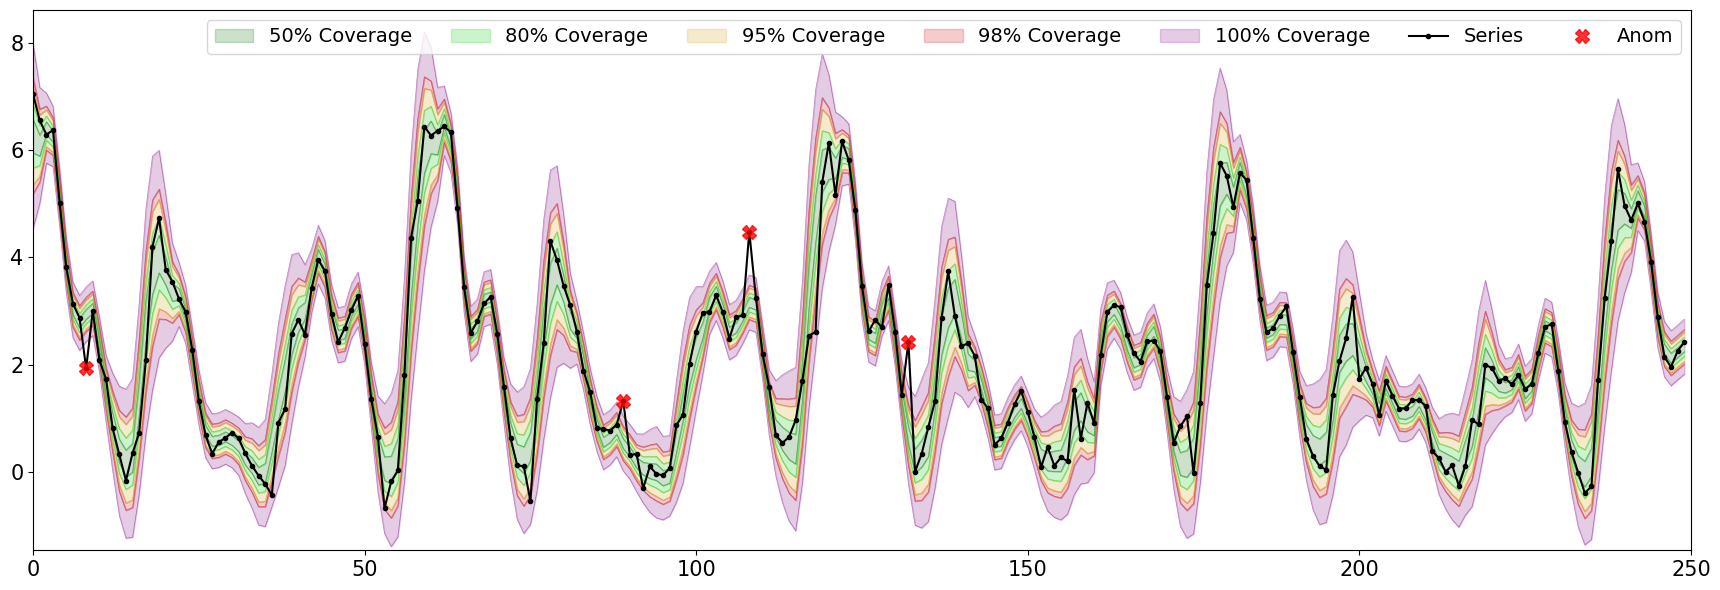

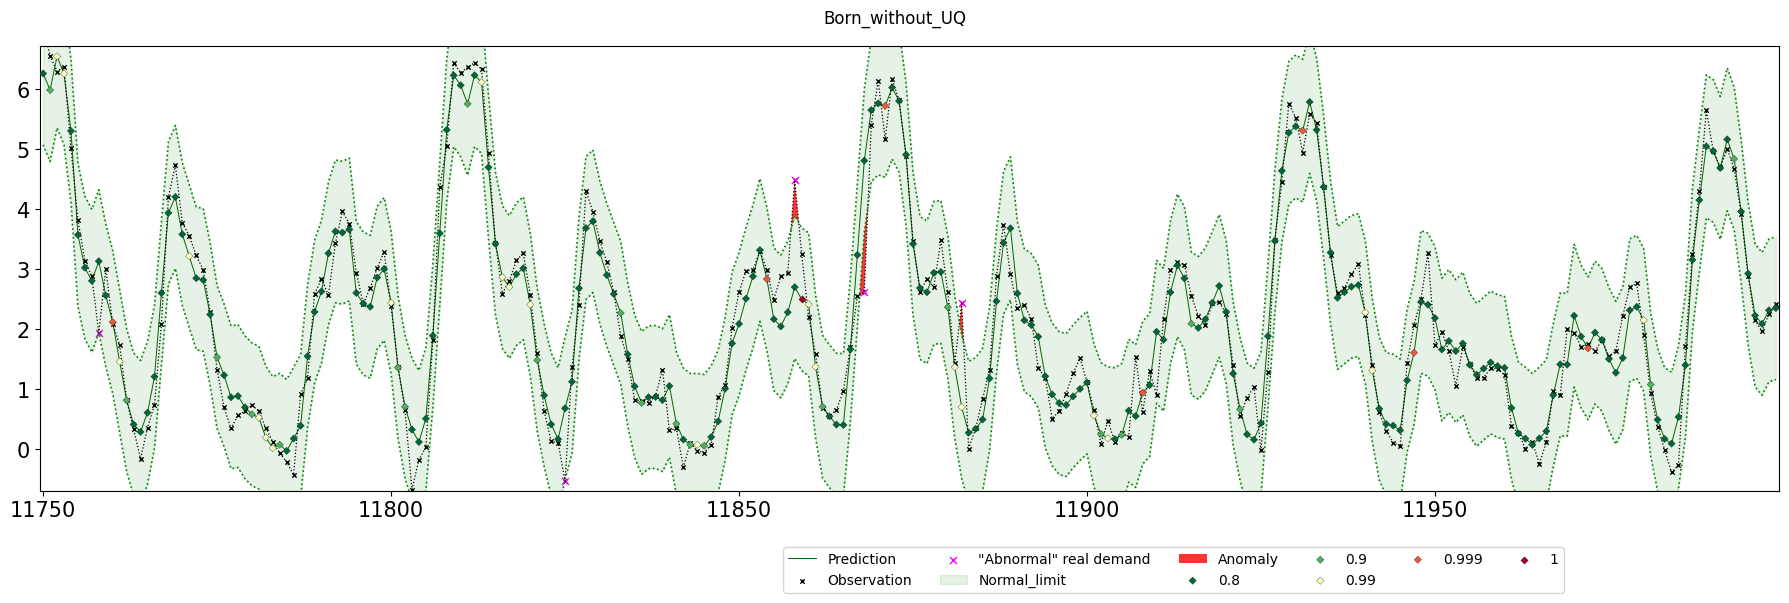

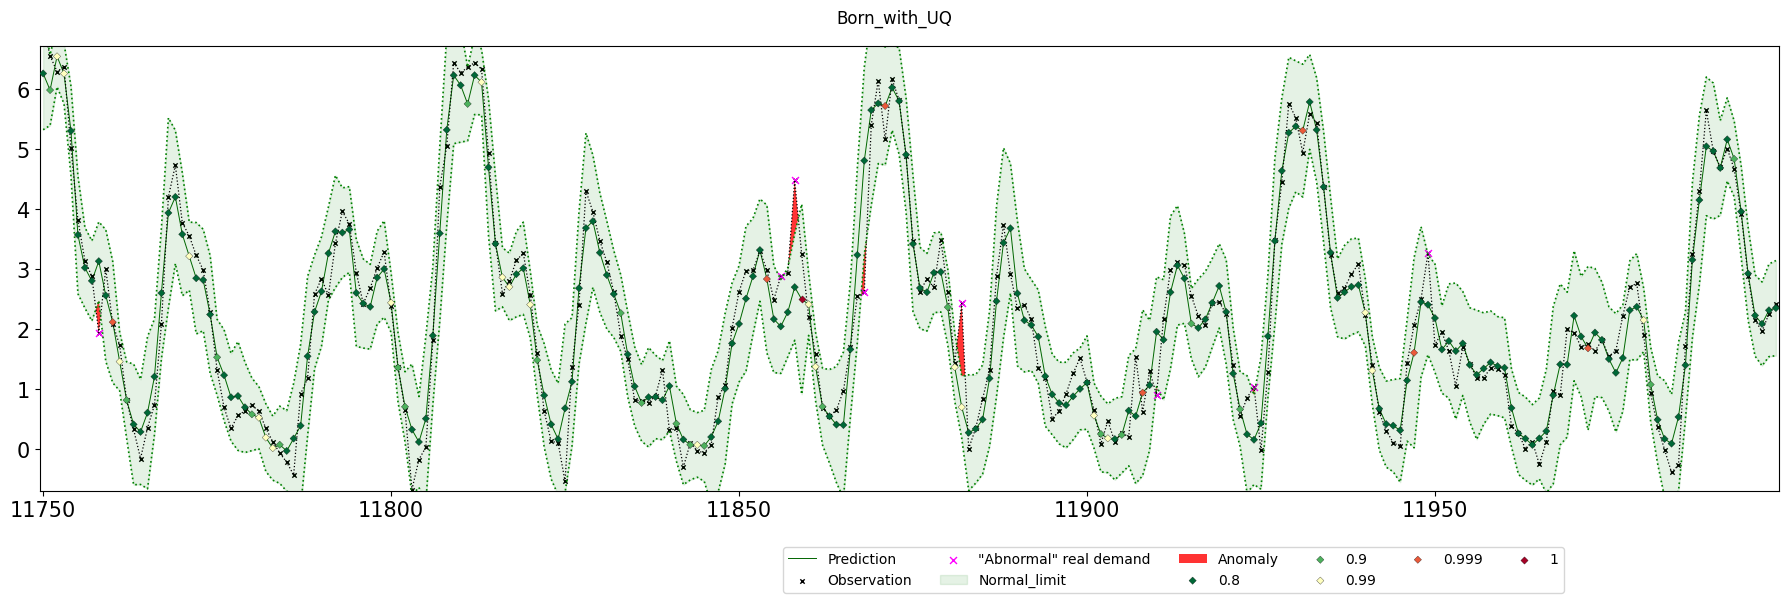

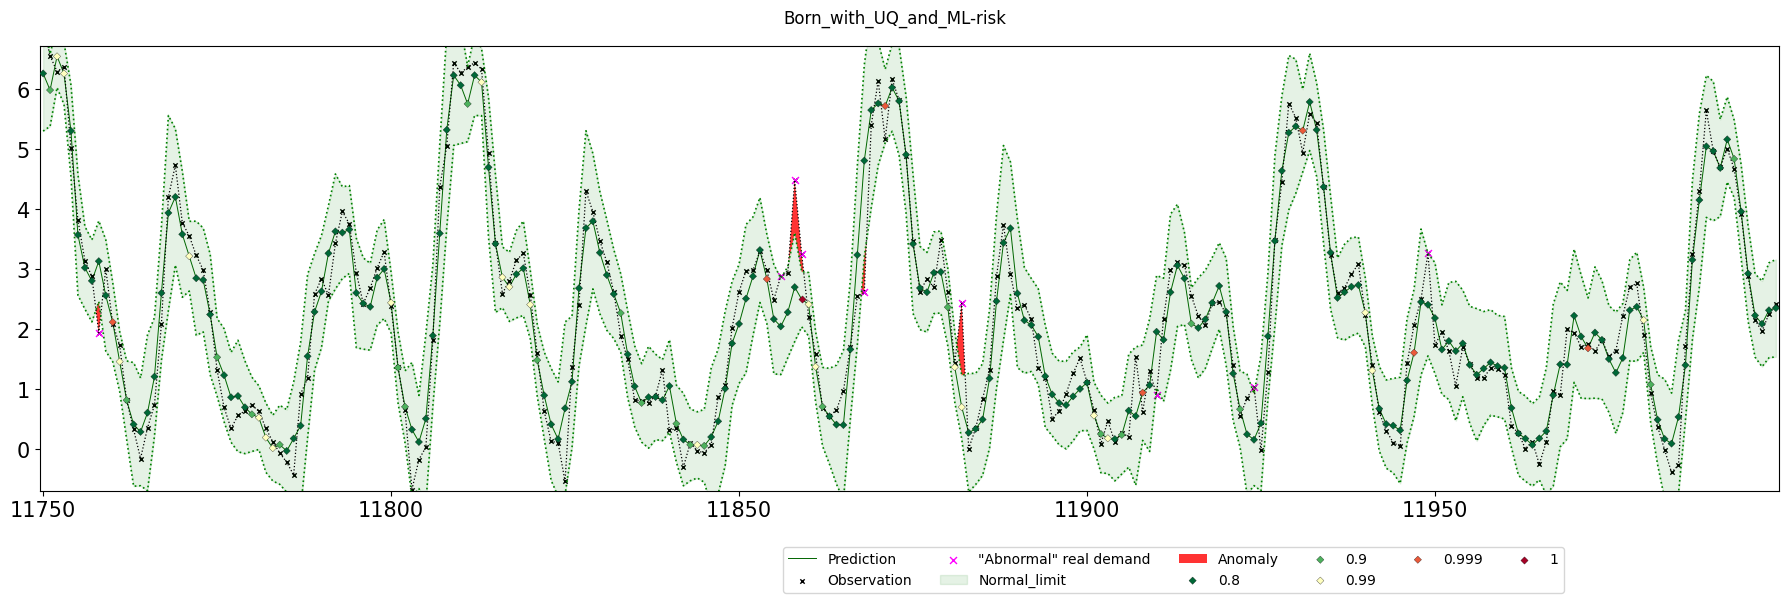

In [15]:
f_obs = np.arange(11750,12000)
dim = 1
fig_s = (18,6)
output = pred,UQ

visu.plot_var(dict_data['Y'],dict_data['aux']['data_mean_dyn'],dict_data['aux'][ 'var_stat'],dict_data['aux']['impact_anom'],dict_data['aux']['anom'],f_obs,dict_data['aux']['dim'],dim,fig_s=fig_s)
visu.uncertainty_plot(y,output,born=born_no_UQ,context=None,size=fig_s,f_obs=f_obs,name='Born_without_UQ',mode_res=False,dim=dim,type_UQ='var_A&E')
visu.uncertainty_plot(y,output,born=born_without_epistemic,context=None,size=fig_s,f_obs=f_obs,name='Born_with_UQ',mode_res=False,dim=dim,type_UQ='var_A&E')
visu.uncertainty_plot(y,output,born=born_with_epistemic,context=None,size=fig_s,f_obs=f_obs,name='Born_with_UQ_and_ML-risk',mode_res=False,dim=dim,type_UQ='var_A&E')

In [16]:
from uqmodels.evaluation.metrics import Generic_metric, rmse, UQ_average_coverage, UQ_sharpness, UQ_Gaussian_NLL, UQ_dEI, UQ_absolute_residu_score
list_ctx_constraint= None
if(True):
    list_metrics=[ Generic_metric(rmse,'Root mean square', mask=None,list_ctx_constraint=list_ctx_constraint,reduce=True),
                   Generic_metric(UQ_average_coverage,"Coverage", mask=None,list_ctx_constraint=list_ctx_constraint,reduce=True,type_UQ=RF_UQModel.type_UQ),
                   Generic_metric(UQ_sharpness,"Sharpness", mask=None,list_ctx_constraint=list_ctx_constraint,reduce=True,type_UQ=RF_UQModel.type_UQ),
                   Generic_metric(UQ_Gaussian_NLL,"NLL", mask=None,list_ctx_constraint=list_ctx_constraint,reduce=True,type_UQ=RF_UQModel.type_UQ),
                   Generic_metric(UQ_dEI,"Epistemic_indicator", mask=None,list_ctx_constraint=list_ctx_constraint,reduce=True,type_UQ=RF_UQModel.type_UQ),
                   Generic_metric(UQ_absolute_residu_score,"Anom_score", mask=None,list_ctx_constraint=list_ctx_constraint,reduce=True,type_UQ=RF_UQModel.type_UQ)]


commentary = ['Error increase between test and anom due to anomaly',
              'Coverage loss between test and anom anomaly',
              'Sharpness increase between test and after-anom to incertainty caused by the anomaly (in lag feature)',
              'NLL increase between test and anom du to anomaly',
              'Epistemic confidence increase between test and after-anomaly due to an OOD input that contain the abnormal lag values',
              'Anom score between test and anom du to anomalie']

print("Metrics evaluation apply on (pred,UQ)")    

for i,metrics in enumerate(list_metrics):
    print("")
    mask_anom = (dict_data['aux']['anom']>0.5)
    mask_anom_after_anom = (np.roll(dict_data['aux']['anom'],1)+np.roll(dict_data['aux']['anom'],2))>0.5
    perf = metrics.compute(y,output,[train,test,test&mask_anom,test&mask_anom_after_anom],context=None)
    print(metrics.name,'train :',np.round(perf[0],3),'test :',np.round(perf[1],3),'Anom :',np.round(perf[2],3),'After_anom :',np.round(perf[3],3),'|commentary :',commentary[i])

Metrics evaluation apply on (pred,UQ)

Root mean square train : 0.327 test : 0.438 Anom : 1.854 After_anom : 0.678 |commentary : Error increase between test and anom due to anomaly

Coverage train : 0.996 test : 0.977 Anom : 0.2 After_anom : 0.944 |commentary : Coverage loss between test and anom anomaly

Sharpness train : 1.798 test : 1.882 Anom : 1.977 After_anom : 2.476 |commentary : Sharpness increase between test and after-anom to incertainty caused by the anomaly (in lag feature)

NLL train : -0.287 test : -0.496 Anom : -4.83 After_anom : -0.935 |commentary : NLL increase between test and anom du to anomaly

Epistemic_indicator train : -0.472 test : -0.428 Anom : -0.41 After_anom : -0.313 |commentary : Epistemic confidence increase between test and after-anomaly due to an OOD input that contain the abnormal lag values

Anom_score train : 0.388 test : 0.756 Anom : 12.711 After_anom : 1.195 |commentary : Anom score between test and anom du to anomalie
